In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import pywhatkit

In [2]:
import numpy as np

class SVM:
    def __init__(self, learning_rate=0.2, lambda_param=0.01, n_iters=10000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y_binary = np.where(y == 'A', 1, 0)
    
        self.w = np.zeros(n_features).astype(np.int64)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                result = np.dot(x_i, self.w)
                result = result.astype(np.int64)
                condition = y_binary[idx] * (result - self.b) >= 1
                
                if condition:
                    self.w -= (self.lr * (2 * self.lambda_param * self.w)).astype(np.int64)
                else:
                    self.w -= (self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_binary[idx]))).astype(np.int64)
                    self.b -= self.lr * y_binary[idx]


    def predict(self, X, b=None):
        if self.w is None:
            w = np.ones(X.shape[1])
        else:
            w = self.w
        b = float(self.b) if b is None else b
        
        approx = np.dot(X, w) - b
        
        return np.sign(approx)

In [3]:
df = pd.read_csv('final.csv')

In [4]:
df.shape

(149043, 14)

In [5]:
print(df.columns)

Index(['Time', 'Protcol', 'Flag', 'Family', 'Clusters', 'SeddAddress',
       'ExpAddress', 'BTC', 'USD', 'Netflow_Bytes', 'IPaddress', 'Threats',
       'Port', 'Prediction'],
      dtype='object')


In [6]:
df.head()

,Time,Protcol,Flag,Family,Clusters,SeddAddress,ExpAddress,BTC,USD,Netflow_Bytes,IPaddress,Threats,Port,Prediction
0,50,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,500,5,A,Bonet,5061,SS
1,40,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,504,8,A,Bonet,5061,SS
2,30,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,508,7,A,Bonet,5061,SS
3,20,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,512,15,A,Bonet,5061,SS
4,57,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,516,9,A,Bonet,5061,SS


In [7]:
df.dtypes

Time              int64
Protcol          object
Flag             object
Family           object
Clusters          int64
SeddAddress      object
ExpAddress       object
BTC               int64
USD               int64
Netflow_Bytes     int64
IPaddress        object
Threats          object
Port              int64
Prediction       object
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149043 entries, 0 to 149042
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Time           149043 non-null  int64 
 1   Protcol        149043 non-null  object
 2   Flag           149043 non-null  object
 3   Family         149043 non-null  object
 4   Clusters       149043 non-null  int64 
 5   SeddAddress    149043 non-null  object
 6   ExpAddress     149043 non-null  object
 7   BTC            149043 non-null  int64 
 8   USD            149043 non-null  int64 
 9   Netflow_Bytes  149043 non-null  int64 
 10  IPaddress      149043 non-null  object
 11  Threats        149043 non-null  object
 12  Port           149043 non-null  int64 
 13  Prediction     149043 non-null  object
dtypes: int64(6), object(8)
memory usage: 15.9+ MB


<AxesSubplot:>

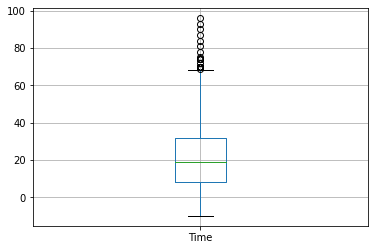

In [9]:
df.boxplot(column='Time')

<AxesSubplot:>

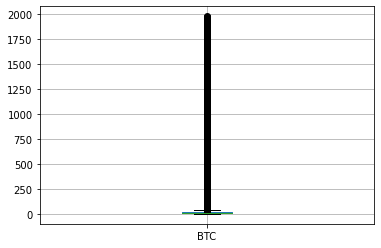

In [10]:
df.boxplot(column='BTC')

<AxesSubplot:>

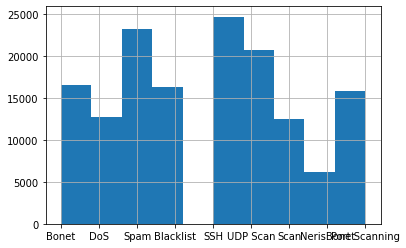

In [11]:
df['Threats'].hist()

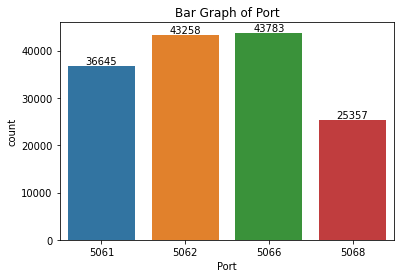

In [12]:
ax = sns.countplot(x=df['Port'], data=df)
plt.title('Bar Graph of Port')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

In [13]:
encoder = LabelEncoder()
df['Protcol'] = encoder.fit_transform(df['Protcol'])
df['SeddAddress'] = encoder.fit_transform(df['SeddAddress'])
df['ExpAddress'] = encoder.fit_transform(df['ExpAddress'])
df['Time'] = encoder.fit_transform(df['Time'])
df['IPaddress'] = encoder.fit_transform(df['IPaddress'])
df['Prediction'] = np.where(df['Prediction'] == 'A' , 1, 0)

df = df.drop('USD', axis=1)
df = df.drop('Flag', axis=1)
df = df.drop('Family', axis=1)
df = df.drop('Threats', axis=1)
df = df.drop('BTC', axis=1)
df = df.drop('Netflow_Bytes', axis=1)
df = df.drop('Clusters', axis=1)



# Split data into features and target
X = df.drop('Prediction', axis=1)
y = df['Prediction']

In [14]:
df.head()

,Time,Protcol,SeddAddress,ExpAddress,IPaddress,Port,Prediction
0,56,1,2,2,0,5061,0
1,46,1,2,2,0,5061,0
2,36,1,2,2,0,5061,0
3,26,1,2,2,0,5061,0
4,63,1,2,2,0,5061,0


In [15]:
def preprocess_data(df):

    # Split features and target variable
    X = df.drop('Prediction', axis=1)
    y = df['Prediction']
    return X, y

In [16]:
# Function to predict intrusion
def predict_intrusion(model, X):
    return model.predict(X)

In [17]:
# Preprocess data
X, y = preprocess_data(df)

In [18]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=13)

In [19]:
# Train SVM model
X_train_array = X_train.iloc[:, 1:].values
X_test_array = X_test.iloc[:, 1:].values
svm = SVM()
svm.fit(X_train_array, y)

In [20]:
# Make predictions on the testing set
y_pred = svm.predict(X_test_array)

In [21]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.717106881667524


In [22]:
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted')
f_measure = ((2 * precision * recall) / (precision + recall))
print("Precision:", precision)
print("Recall:", recall)
print("F-measure:", f_measure)

Precision: 0.7975699088979152
Recall: 0.7181052702204033
F-measure: 0.755754482015028


/home/test/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [23]:
import asyncio
import nest_asyncio
import pyshark
import csv

async def packet_capture():
    capture = pyshark.LiveCapture(interface='ens33')
    with open('output.csv', 'w', newline='') as csvfile:
        fieldnames = ['frame.number', 'frame.time', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for packet in capture.sniff_continuously(packet_count=10):
            print(packet)
            if 'ip' in packet:
                ip_src = packet.ip.src
                ip_dst = packet.ip.dst
            else:
                ip_src = ip_dst = ''

            # Check if the packet has a TCP layer
            if 'tcp' in packet:
                tcp_srcport = packet.tcp.srcport
                tcp_dstport = packet.tcp.dstport
            else:
                tcp_srcport = tcp_dstport = ''
            frame_number = packet.frame_info.number
            frame_time = packet.sniff_time
            tcp_srcport = packet.tcp.srcport if 'tcp' in packet else ''
            tcp_dstport = packet.tcp.dstport if 'tcp' in packet else ''
        
            writer.writerow({
                'frame.number': frame_number,
                'frame.time': frame_time,
                'ip.src': ip_src,
                'ip.dst': ip_dst,
                'tcp.srcport': tcp_srcport,
                'tcp.dstport': tcp_dstport
            })


            

def prediction_generate(packets, predictions):
    intrusion_values = []
    for index, packet in packets.iterrows():
        if packet['tcp.dstport'] == 678:
            intrusion_values.append(1)
        else:
            intrusion_values.append(predictions[index])
    packets['Intrusion'] = intrusion_values           
            
            
            
# Apply nest_asyncio to allow nested event loops in Jupyter Notebook                                                                                                                                   
#nest_asyncio.apply()

# Create a new event loop
#loop = asyncio.get_event_loop()

# Run the coroutine within the event loop
#loop.run_until_complete(packet_capture())

In [24]:
# Function to preprocess captured data
def preprocess_captured_data(df):
    
    df = df.drop('frame.time', axis=1)
    
    df['ip.src'] = encoder.fit_transform(df['ip.src'])  
    df['ip.dst'] = encoder.fit_transform(df['ip.dst'])
    df['tcp.dstport'] = encoder.fit_transform(df['tcp.dstport'])
    df['frame.number'] = encoder.fit_transform(df['frame.number'])
    df['tcp.srcport'] = encoder.fit_transform(df['tcp.srcport'])

    return df

In [25]:
# import joblib

# joblib.dump(svm, 'svm_model.joblib')

In [26]:
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

def send_email(sender_email, receiver_email, subject, message_body, smtp_server, smtp_port, smtp_username, smtp_password):
    message = MIMEMultipart()
    message['From'] = sender_email
    message['To'] = receiver_email
    message['Subject'] = subject

    message.attach(MIMEText(message_body, 'plain'))

    with smtplib.SMTP(smtp_server, smtp_port) as server:
        server.starttls()
        server.login(smtp_username, smtp_password)
        server.send_message(message)


sender_email = 'alertnids@gmail.com'
receiver_email = 'suyashadhikari99@gmail.com'
subject = 'Intrusion Detected'
message_body = 'We have detected an intrusion in your network. Please look out for attackers trying to breach your data'
smtp_server = 'smtp.gmail.com'  
smtp_port = 587
smtp_username = 'alertnids@gmail.com'
smtp_password = 'qdnt htih hbic revy'


# send_email(sender_email, receiver_email, subject, message_body, smtp_server, smtp_port, smtp_username, smtp_password)


In [27]:
from scapy.all import *
import ipywidgets as widgets
from IPython.display import display


def get_if_list():
    return ['ens33']

interface_dropdown = widgets.Dropdown(
    options=get_if_list(),
    description='Interface:'
)

packet_count_input = widgets.IntText(
    value=10,
    description='Packet Count:'
)

capture_button = widgets.Button(
    description='Start Capturing'
)

report_button = widgets.Button(
    description='Show Report'
)

output_widget = widgets.Output()

# Define event handlers
def on_capture_button_clicked(b):
    output_widget.clear_output(wait=True)
    with output_widget:
        # Apply nest_asyncio to allow nested event loops in Jupyter Notebook
        nest_asyncio.apply()

        # Create a new event loop
        loop = asyncio.get_event_loop()

        # Run the coroutine within the event loop
        loop.run_until_complete(packet_capture())
        

def prediction_generate(packets, predictions):
    intrusion_values = []
    for index, packet in packets.iterrows():
        if packet['tcp.dstport'] in [5066, 5061, 5062, 5068]:
            intrusion_values.append(1)
        else:
            intrusion_values.append(predictions[index])
    packets['Intrusion'] = intrusion_values
        
        
def post_task(b):
        packets = pd.read_csv('output.csv')
        flag = 0
        processed_packets = preprocess_captured_data(packets)
        predictions = svm.predict(processed_packets)
        prediction_generate(packets, predictions)
        print(packets)
        for index, row in packets.iterrows():
            if row['Intrusion'] == 1:
                flag = 1
        if flag==1:
            send_email(sender_email, receiver_email, subject, message_body, smtp_server, smtp_port, smtp_username, smtp_password)
            pywhatkit.sendwhatmsg_to_group_instantly("HiNZLYyIFczBxqeErlLp22", "NIDS Alert!!!!\nIntrusion Detected in your system", 35, True)
        
    


# Assign event handlers
capture_button.on_click(on_capture_button_clicked)
report_button.on_click(post_task)

# Display widgets
display(interface_dropdown)
display(packet_count_input)
display(capture_button)
display(report_button)
display(output_widget)


Dropdown(description='Interface:', options=('ens33',), value='ens33')

IntText(value=10, description='Packet Count:')

Button(description='Start Capturing', style=ButtonStyle())

Button(description='Show Report', style=ButtonStyle())

Output()